In [1]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%load_ext autoreload
%autoreload 2
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/owkin/ngot_wp_2/deepdeconv/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/owkin/ngot_wp_2/deepdeconv/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


# 1. Loading the models trained by Khalil

In [2]:
#adata = ad.read_h5ad("/home/owkin/project/scvi_models/data/adata_toy_1200.h5ad")
adata = ad.read_h5ad("/home/owkin/project/scvi_models/data/adata_cti_5000.h5ad")
adata.obs

,donor_id,Predicted_labels_CellTypist,Majority_voting_CellTypist,Majority_voting_CellTypist_high,Manually_curated_celltype,assay_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,cell_types_grouped,_scvi_batch,_scvi_labels
Pan_T7935490_AAACCTGCAAATTGCC,A29,Type 17 helper T cells,Tem/Effector helper T cells,T cells,Trm_Th1/Th17,EFO:0011025,CL:0000492,HsapDv:0000241,PATO:0000461,unknown,...,10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage,TNK,0,2
Pan_T7935490_AAACGGGCATCTGGTA,A29,Cytotoxic T cells,Cytotoxic T cells,T cells,Trm_gut_CD8,EFO:0011025,CL:0000909,HsapDv:0000241,PATO:0000461,unknown,...,10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage,TNK,0,23
Pan_T7935490_AAACGGGTCTTGCATT,A29,Tem/Effector cytotoxic T cells,Cytotoxic T cells,T cells,Trm_gut_CD8,EFO:0011025,CL:0000909,HsapDv:0000241,PATO:0000461,unknown,...,10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage,TNK,0,23
Pan_T7935490_AAAGCAATCATCGCTC,A29,Cytotoxic T cells,Cytotoxic T cells,T cells,Trm_gut_CD8,EFO:0011025,CL:0000909,HsapDv:0000241,PATO:0000461,unknown,...,10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage,TNK,0,23
Pan_T7935490_AAAGTAGCAGTCACTA,A29,gamma-delta T cells,gamma-delta T cells,T cells,Trm_Tgd,EFO:0011025,CL:0000798,HsapDv:0000241,PATO:0000461,unknown,...,10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage,TNK,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CZINY-0112_TTTGGTTAGGCCACTC,D496,MAIT cells,Cytotoxic T cells,T cells,Trm_gut_CD8,EFO:0009922,CL:0000909,HsapDv:0000240,PATO:0000461,unknown,...,10x 3' v3,normal,Homo sapiens,male,jejunal epithelium,unknown,sixth decade human stage,TNK,0,23
CZINY-0112_TTTGGTTCACAAAGTA,D496,Helper T cells,Helper T cells,T cells,Tfh,EFO:0009922,CL:0002038,HsapDv:0000240,PATO:0000461,unknown,...,10x 3' v3,normal,Homo sapiens,male,spleen,unknown,sixth decade human stage,TNK,0,33
CZINY-0112_TTTGGTTTCCATCACC,D496,Cytotoxic T cells,Cytotoxic T cells,T cells,Tem/emra_CD8,EFO:0009922,CL:0001062,HsapDv:0000240,PATO:0000461,unknown,...,10x 3' v3,normal,Homo sapiens,male,lung,unknown,sixth decade human stage,TNK,0,30
CZINY-0112_TTTGTTGCAGCGGTTC,D496,Helper T cells,Helper T cells,T cells,Tfh,EFO:0009922,CL:0002038,HsapDv:0000240,PATO:0000461,unknown,...,10x 3' v3,normal,Homo sapiens,male,spleen,unknown,sixth decade human stage,TNK,0,33


In [24]:
adata.layers

Layers with keys: counts

In [3]:
models = {}
for nepochs in [100,200,400]:

    models[nepochs] = scvi.model.SCVI.load(dir_path=f"/home/owkin/project/scvi_models/models/cti_{nepochs}_epochs",
                                 adata=adata,
                                 use_gpu=True
                                 )
    
    models[nepochs].view_anndata_setup()


INFO     File /home/owkin/project/scvi_models/models/cti_100_epochs/model.pt already downloaded                    


/home/owkin/ngot_wp_2/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['assay', 'donor_id'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 329762 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  5000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['assay']   │ 10x 3' v3  │          0          │
│                       │ 10x 5' v1  │          1          │
│                       │ 10x 5' v2  │          2          │
│                       │            │                     │
│ adata.obs['donor_id'] │    582C    │          0          │
│                       │    621B    │          1          │
│                       │    637C    │          2          │
│                       │    640C    │          3          │
│                       │    A29     │          4          │
│                       │    A31     │          5          │
│                       │    A35     │          6          │
│                       │    A36     │          7          │
│                       │    A37     │          8          │
│                       │    A52     │          9          │
│                       │    D496    │         10          │
│                       │    D503    │         11          │
│                       │            │                     │
└───────────────────────┴────────────┴─────────────────────┘

INFO     File /home/owkin/project/scvi_models/models/cti_200_epochs/model.pt already downloaded                    


/home/owkin/ngot_wp_2/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['assay', 'donor_id'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 329762 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  5000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['assay']   │ 10x 3' v3  │          0          │
│                       │ 10x 5' v1  │          1          │
│                       │ 10x 5' v2  │          2          │
│                       │            │                     │
│ adata.obs['donor_id'] │    582C    │          0          │
│                       │    621B    │          1          │
│                       │    637C    │          2          │
│                       │    640C    │          3          │
│                       │    A29     │          4          │
│                       │    A31     │          5          │
│                       │    A35     │          6          │
│                       │    A36     │          7          │
│                       │    A37     │          8          │
│                       │    A52     │          9          │
│                       │    D496    │         10          │
│                       │    D503    │         11          │
│                       │            │                     │
└───────────────────────┴────────────┴─────────────────────┘

INFO     File /home/owkin/project/scvi_models/models/cti_400_epochs/model.pt already downloaded                    


/home/owkin/ngot_wp_2/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['assay', 'donor_id'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 329762 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  5000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['assay']   │ 10x 3' v3  │          0          │
│                       │ 10x 5' v1  │          1          │
│                       │ 10x 5' v2  │          2          │
│                       │            │                     │
│ adata.obs['donor_id'] │    582C    │          0          │
│                       │    621B    │          1          │
│                       │    637C    │          2          │
│                       │    640C    │          3          │
│                       │    A29     │          4          │
│                       │    A31     │          5          │
│                       │    A35     │          6          │
│                       │    A36     │          7          │
│                       │    A37     │          8          │
│                       │    A52     │          9          │
│                       │    D496    │         10          │
│                       │    D503    │         11          │
│                       │            │                     │
└───────────────────────┴────────────┴─────────────────────┘

Plotting model losses 

Number of training epochs: 100


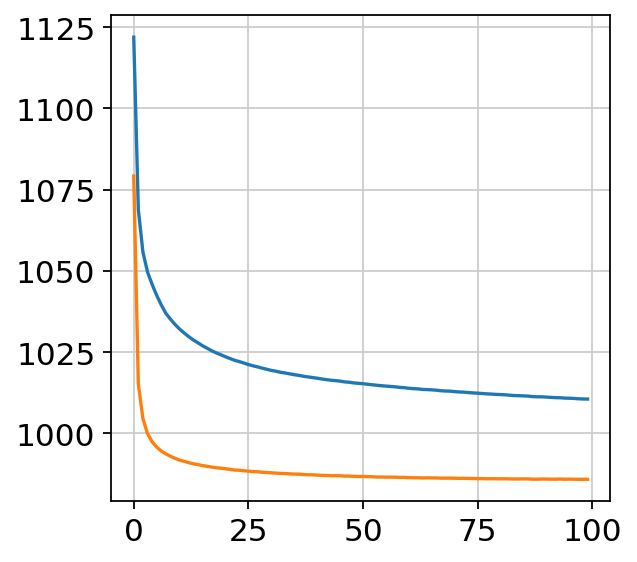

Number of training epochs: 200


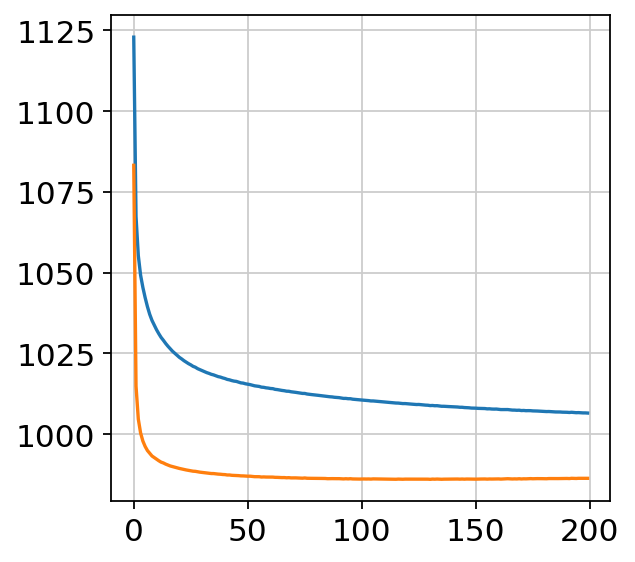

Number of training epochs: 400


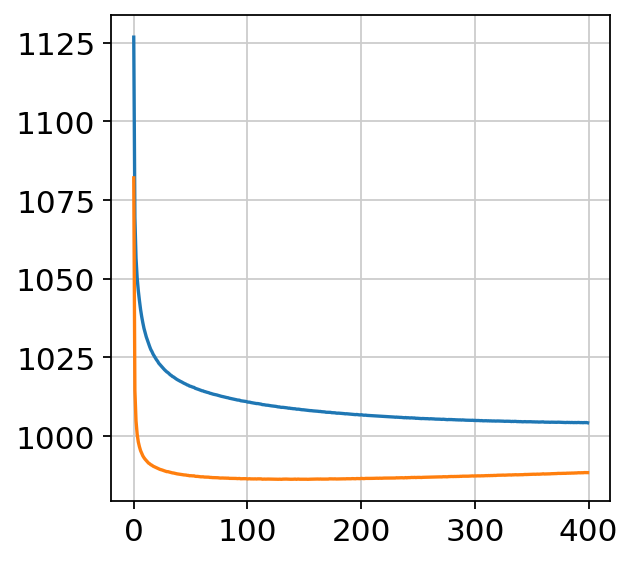

In [4]:
for nepochs, model in models.items():
    print(f"Number of training epochs: {nepochs}")
    plt.plot(model.history["elbo_train"])
    plt.plot(model.history["reconstruction_loss_train"])
    plt.show()

# 2. Creating a signature matrix in latent space 

## 2.0 Latent space representation

In [7]:
def plot_model(models,key):
    model =models[key]
    # Regular scVI
    latent = model.get_latent_representation()
    adata.obsm[f"X_scvi_{key}"] = latent
    
    
    # run PCA then generate UMAP plots
    # sc.tl.pca(adata,use_rep = "X_scvi")
    #pca = sc.tl.pca(latent)[:,:2]
    #adata.obsm[f"X_pca_{key}"]=pca
    #sc.pp.neighbors(adata, use_rep=f"X_scvi_{key}")
    #sc.tl.umap(adata, min_dist=0.3)

    #sc.pl.umap(
    #    adata,
    #    color=["cell_types_grouped"],
    #    frameon=False,
    #)
    #adata.obsm["X_pca"] = pca
    #sc.pl.pca(adata,color=["cell_types_grouped"])

    

In [8]:
for key in models:
    print(f"CTI model with {key} epochs")
    plot_model(models,key)


CTI model with 100 epochs
CTI model with 200 epochs
CTI model with 400 epochs


## 2.1 Effect of averaging multiple latent representations of single cells 

The goal here is to average multiple latent representations of single cells OF THE SAME CELL TYPE, and see the effect 

In [12]:
from scvi_sanity_checks_utils import create_anndata_pseudobulk
import random
import numpy as np

def make_signature(models,key,adata,number_single_cells,number_repeats,before = True):
    model = models[key]
    cell_type_list = []
    representation_list = []
    for cell_type in adata.obs["cell_types_grouped"].unique():
        for repeat in range(number_repeats):
            seed = random.seed()
            sampled_cells = adata.obs[adata.obs['cell_types_grouped'] == cell_type].sample(n=number_single_cells,
                                                                                random_state=seed,replace = True).index
            #print(sampled_cells[:5])
            # Select the sampled cells from the DataFrame
            adata_sampled = adata[sampled_cells]
            if before:
                latent_sampled = adata.obsm[f"X_scvi_{key}"]
                result = latent_sampled.mean(axis = 0)
                result = result/np.linalg.norm(result)
            else:
                pseudobulk = adata_sampled.layers["counts"].mean(axis=0).reshape(1,-1) #.astype(int).astype(numpy.float32)
                adata_pseudobulk = create_anndata_pseudobulk(adata_sampled, pseudobulk)
                result = model.get_latent_representation(adata_pseudobulk).reshape(-1)
            representation_list.append(result)
            cell_type_list.append(cell_type)
    full_rpz = np.stack(representation_list,axis=0)
    signature_sampled= ad.AnnData(X=full_rpz,obs=pd.DataFrame(pd.Series(cell_type_list,name="cell_types_grouped")))
    return signature_sampled
                
                
            
            
    
    
    
    
    

### 2.1.1 Test if the function works to build signatures

In [13]:
signature_sampled = make_signature(models,400,adata,1000,5,before = False)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Cate

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Cate

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 10 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Cate

In [14]:
signature_sampled.obs["cell_types_grouped"].unique()

array(['TNK', 'MonoMacro', 'B', 'DC', 'To remove', 'Mast'], dtype=object)

In [15]:
# run PCA then generate UMAP plots
sc.pp.neighbors(signature_sampled, use_rep="X")
sc.tl.umap(signature_sampled, min_dist=0.3)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


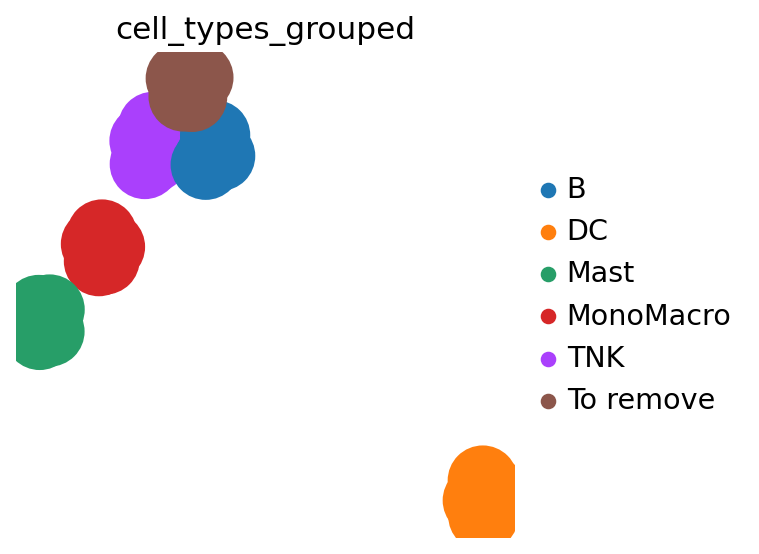

In [16]:
sc.pl.umap(
    signature_sampled,
    color = ["cell_types_grouped"],
    frameon=False,
)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


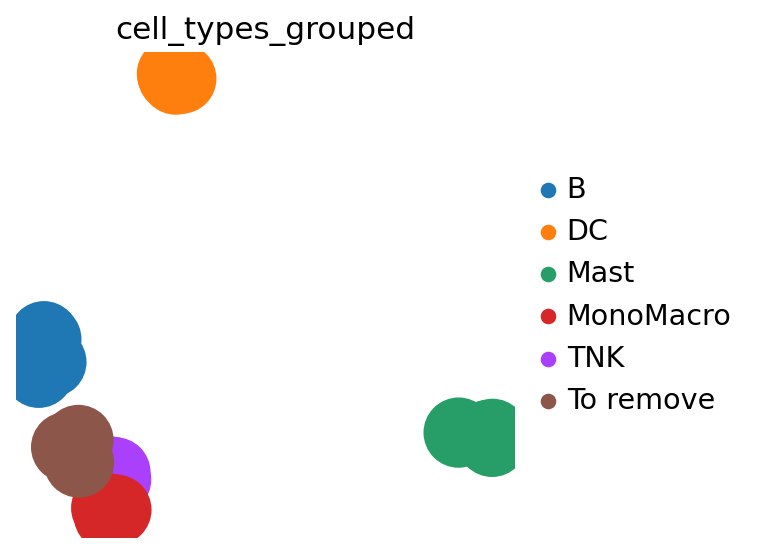

In [17]:
sc.tl.pca(signature_sampled)
sc.pl.pca(
    signature_sampled,
    color = ["cell_types_grouped"],
    frameon=False,
)

### 2.1.2 Creating signatures 

In [18]:
signatures = {}
for key in models:
    signatures[key] = make_signature(models,key,adata,1000,1,before = False)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Cate

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

## 2.2 Scalar multiplication effect

## 2.3 Testing signature 

In [30]:
def create_bulk_embedding_from_proportions(models,key,adata,proportions,total_cells= 11000):
    model = models[key]
    sampled_cells_per_type = proportions * total_cells
    sampled_cells_per_type = sampled_cells_per_type.astype(int)

    cell_types = list(adata.obs['cell_types_grouped'].unique())
    sampled_cells = []
    # Perform stratified sampling for each cell type
    sampled_cells = []
    for index_ct,ct, in enumerate(cell_types):
        seed = random.seed()
        num_cells = sampled_cells_per_type[index_ct]
        sampled_cells.extend(adata.obs[adata.obs['cell_types_grouped'] == ct].sample(n=num_cells,
                                                                                random_state=seed,replace = True).index)
    adata_sampled = adata[sampled_cells]
    pseudobulk = adata_sampled.layers["counts"].mean(axis=0).reshape(1,5000) #.astype(int).astype(numpy.float32)
    adata_pseudobulk = create_anndata_pseudobulk(adata_sampled, pseudobulk)
    result = model.get_latent_representation(adata_pseudobulk).reshape(-1)
    return result

In [35]:
def create_proportion(n_non_zero = 2):
    gt_prop = np.zeros(6,)
    
    gt_prop[:n_non_zero] = np.random.rand(n_non_zero) 
    
    gt_prop = gt_prop/gt_prop.sum()
    return np.random.permutation(gt_prop)

In [36]:
from scipy.optimize import nnls
from scipy.stats import pearsonr




def make_corrs_error(models,signatures,adata,n_non_zero,total_cells= 11000, repeats = 10):
    nmodels = len(list(models.keys()))
    result = np.zeros((nmodels,repeats))
    for i,key in enumerate(list(models.keys())):
        signature= signatures[key].X.T
        for repeat in range(repeats):
            prop = create_proportion(n_non_zero)
            bulk_embedding = create_bulk_embedding_from_proportions(models,key,adata,prop,total_cells= total_cells)
            predprop = nnls(signature,bulk_embedding)[0]
            predprop = predprop/predprop.sum()
            result[i,repeat] = np.dot(prop,predprop)/np.linalg.norm(prop) / np.linalg.norm(predprop)

    return result
            
            
        
        
        
        
    

In [37]:
# Function test
# res = make_corrs_error(models,signatures,adata,3,total_cells= 11000, repeats = 10)

### 2.3.1 Deconvolution on pseudobulks as a function of the number of cell types in the mixture

In [38]:
res_global = {}
for k in range(1,7):
    res_global[k] = make_corrs_error(models,signatures,adata,k,total_cells= 11000, repeats = 20)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['assay'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 11 in adata.obs['donor_id'] ha

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

ValueError: could not broadcast input array from shape (7,) into shape (6,)

#### Plots as a function of the number of epochs

/tmp/ipykernel_10955/3197007068.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(list(models.keys()),
/tmp/ipykernel_10955/3197007068.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(list(models.keys()),


Text(0.5, 1.0, 'Sanity check : simple deconvolution of mixtures using built signature.')

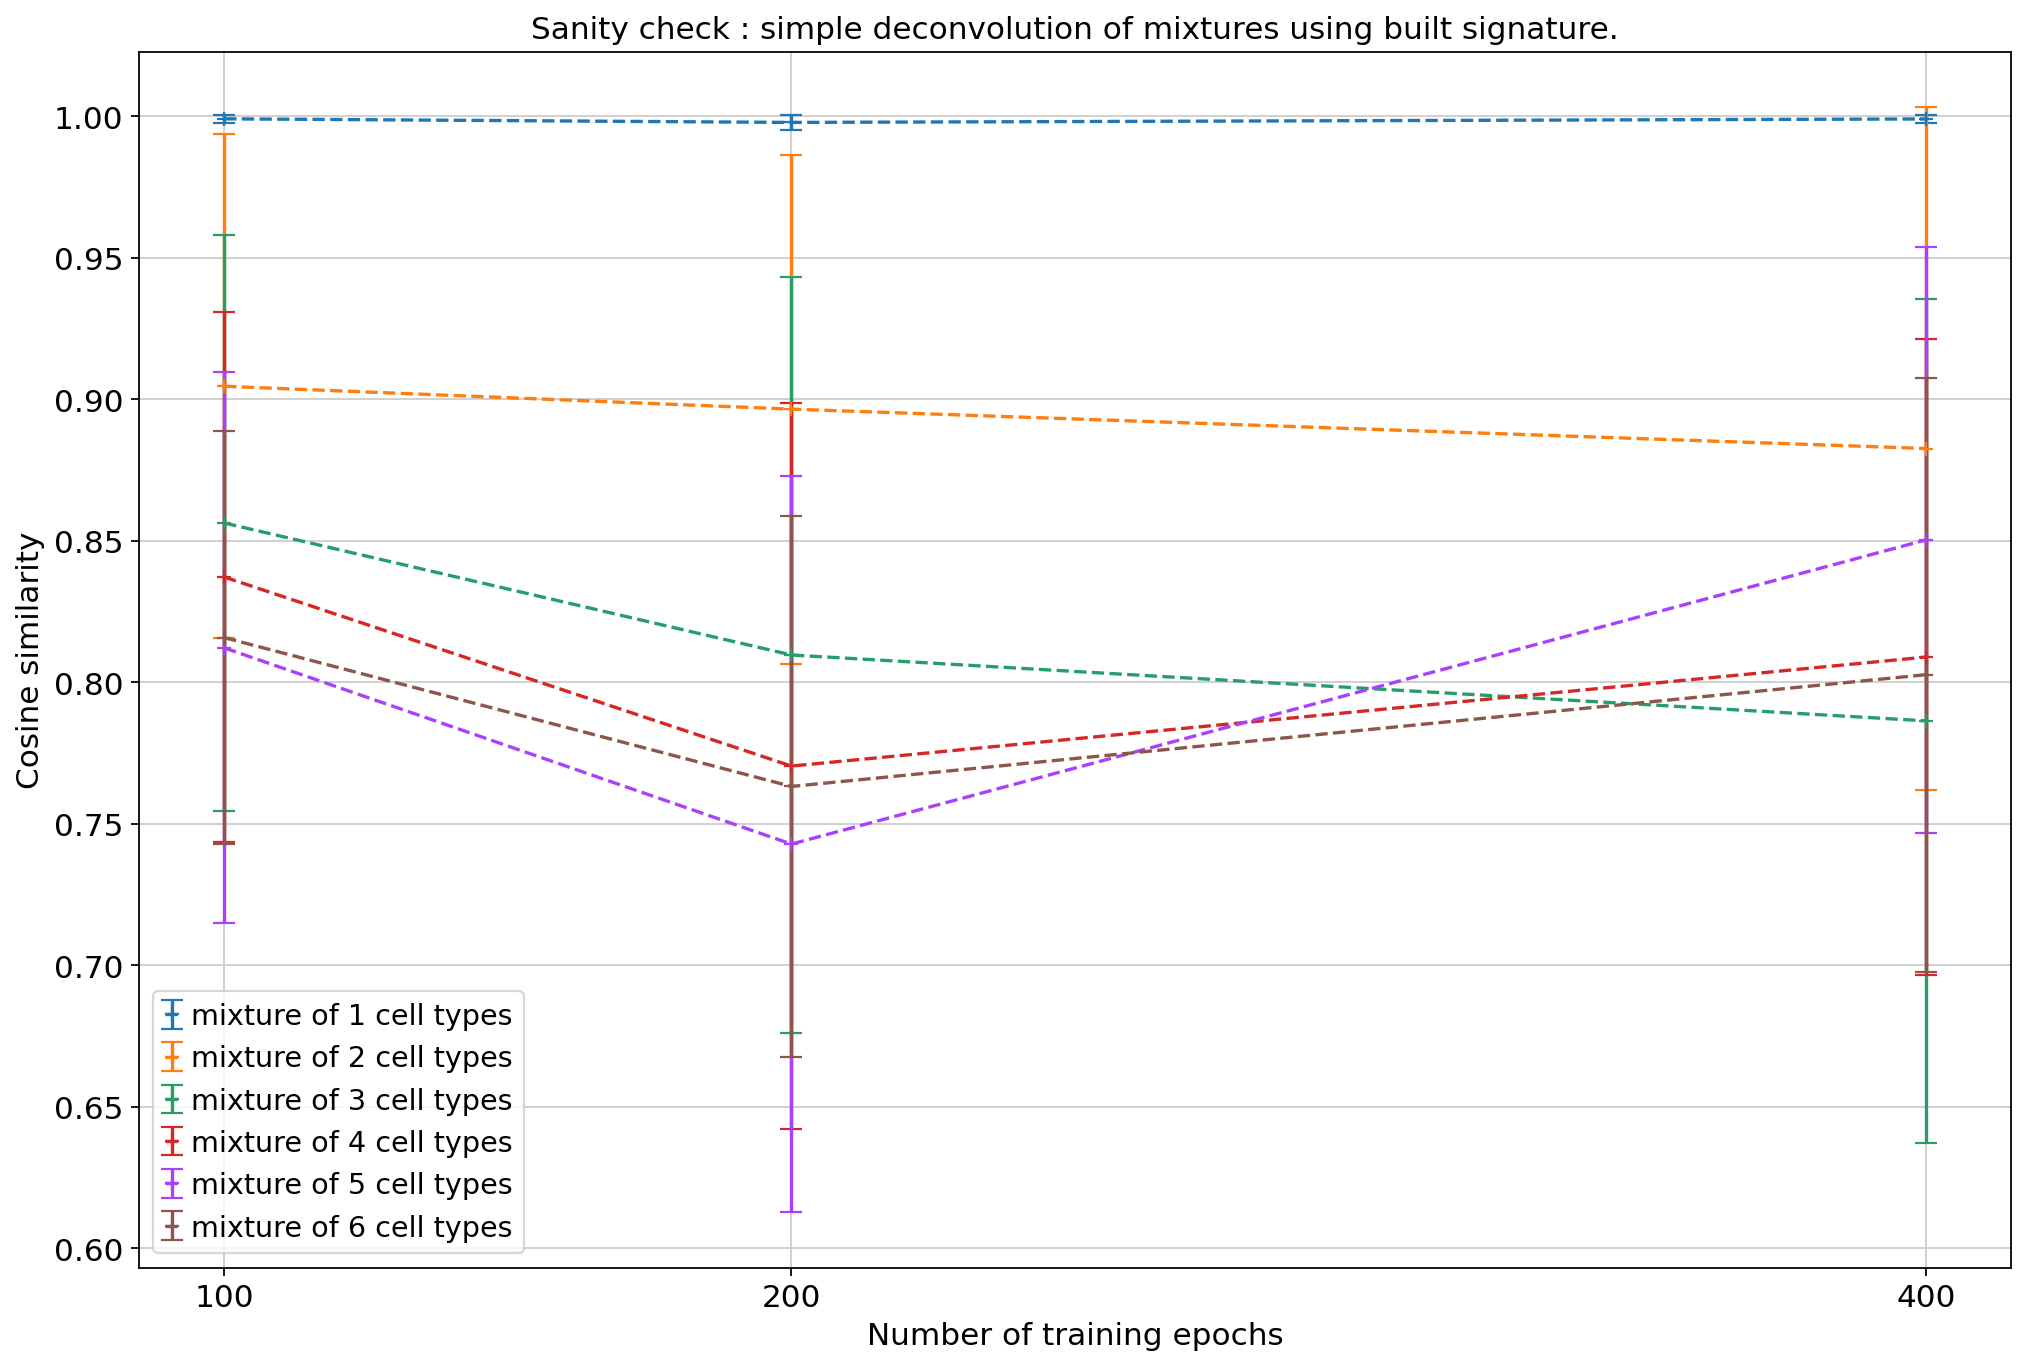

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for nonzero,res in res_global.items():
        plt.errorbar(list(models.keys()),
                res.mean(axis=1),
                yerr=np.std(res,axis=1),
                fmt='o-',
                capsize=5,
                linestyle="--", marker="+",
                label=f"mixture of {nonzero} cell types")

    
plt.legend()  
plt.xlabel("Number of training epochs")
plt.ylabel("Cosine similarity")
plt.xticks(list(models.keys()))

plt.title("Sanity check : simple deconvolution of mixtures using built signature.")

#### Plot as a function of the number of mixtures

In [44]:
result_by_epochs = {}
for i,nepochs in enumerate( list(models.keys())):
    n_repeats = res_global[1].shape[1]
    array_for_nepoch = np.zeros((6,n_repeats))
    for n_mixture in range(1,7):
        for j in range(n_repeats):
            array_for_nepoch[n_mixture-1,j] = res_global[n_mixture][i,j]
    result_by_epochs[nepochs]= array_for_nepoch
        
        
    


/tmp/ipykernel_10955/1108388463.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(list(range(1,7)),
/tmp/ipykernel_10955/1108388463.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(list(range(1,7)),


Text(0.5, 1.0, 'Sanity check : simple deconvolution of mixtures using built signature.')

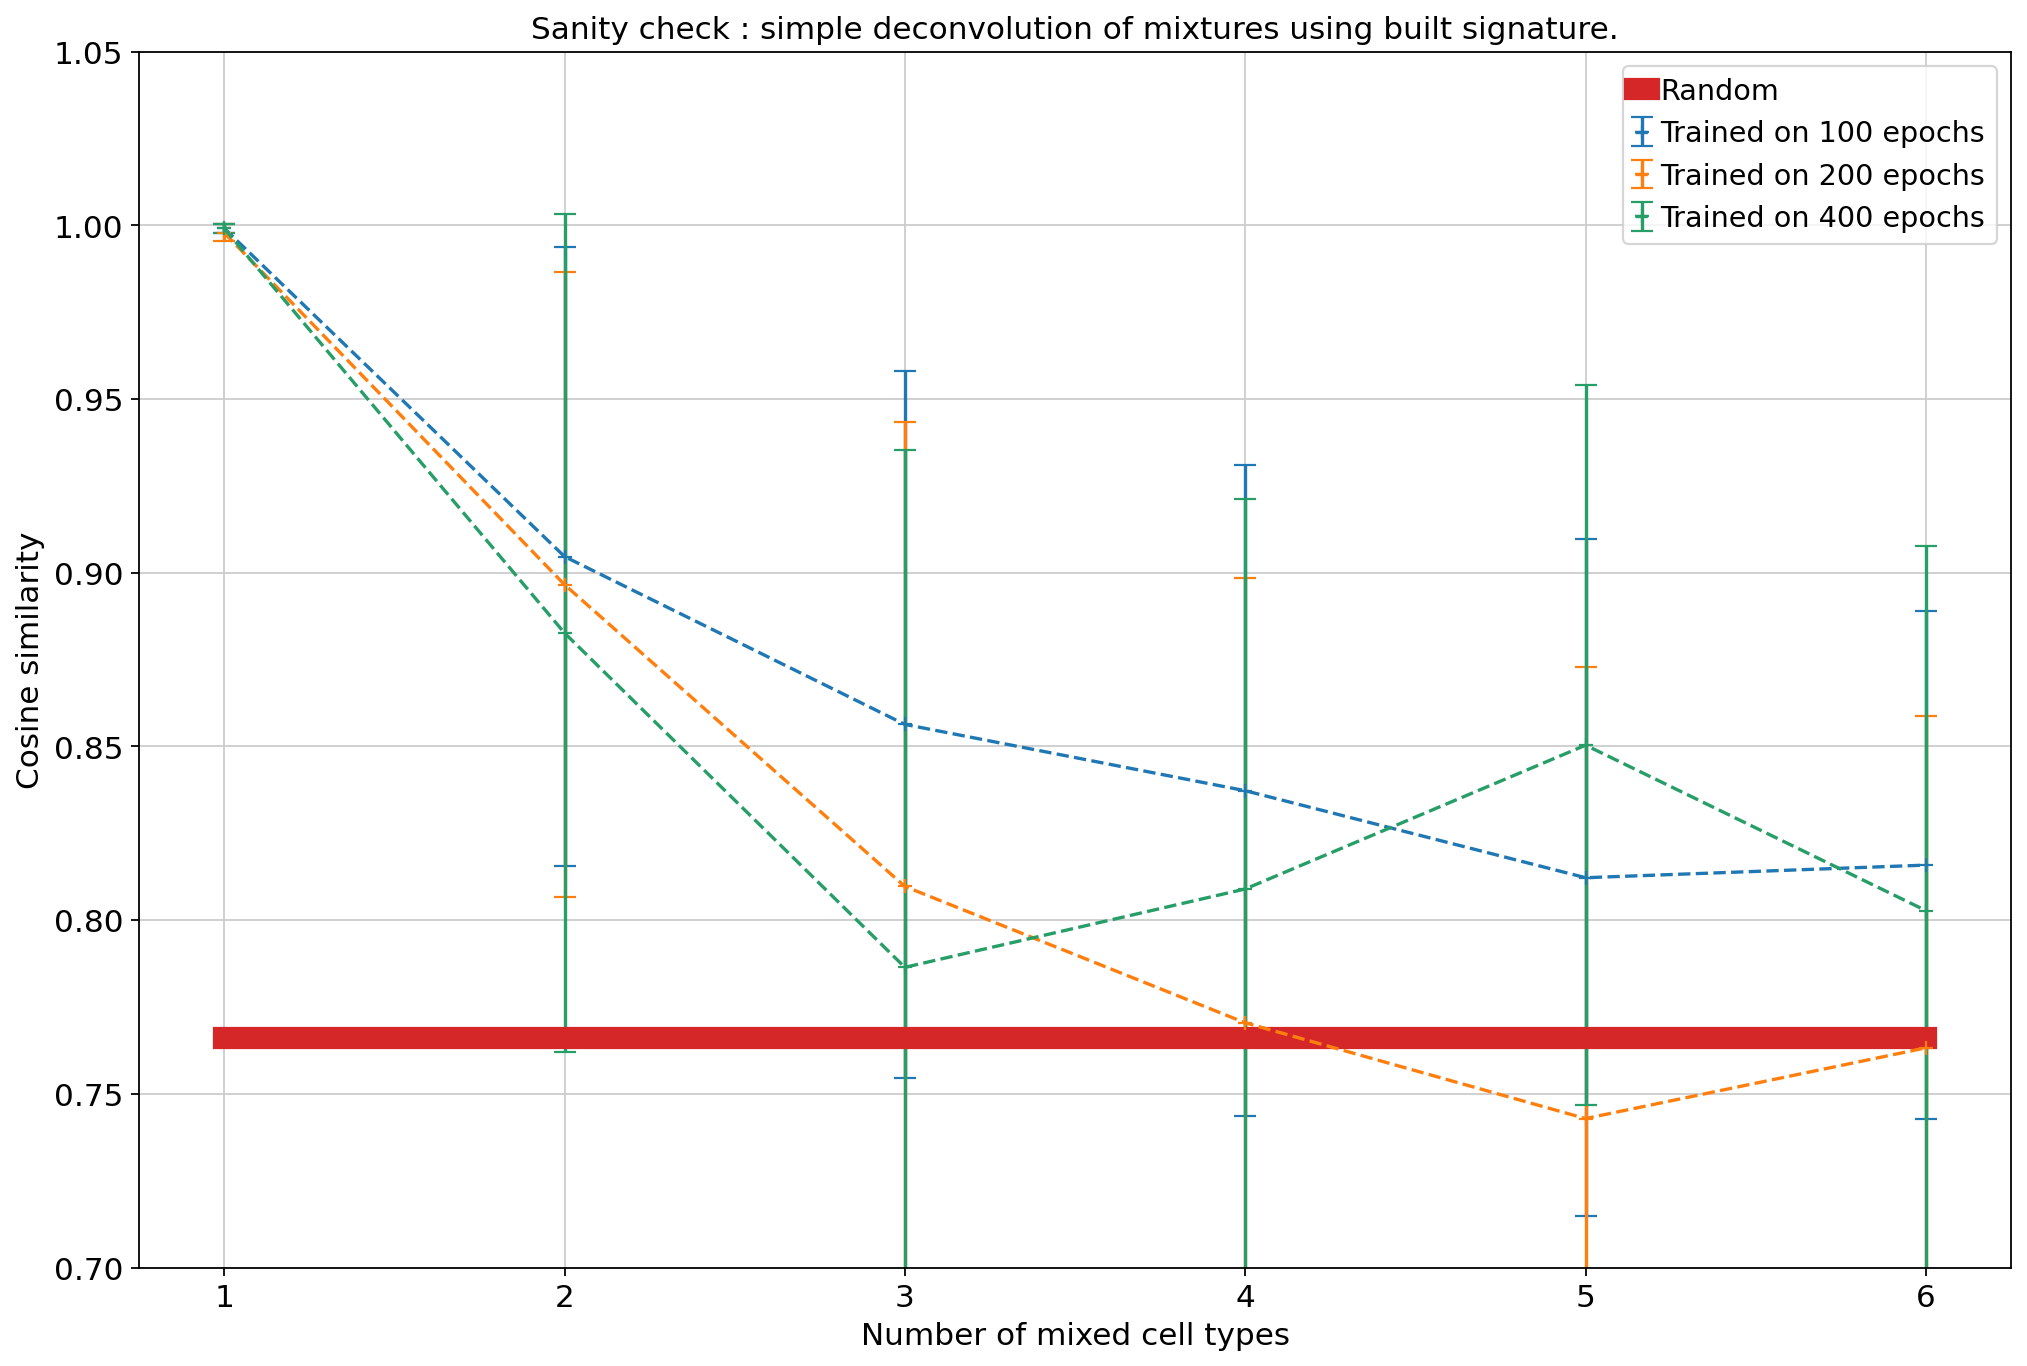

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for nepochs,res in result_by_epochs.items():
        plt.errorbar(list(range(1,7)),
                res.mean(axis=1),
                yerr=np.std(res,axis=1),
                fmt='o-',
                capsize=5,
                linestyle="--", marker="+",
                label=f"Trained on {nepochs} epochs")

plt.plot(list(range(1,7)),[0.766]*6,linewidth=10,label = "Random")   
plt.ylim(0.7,1.05)
plt.legend()  
plt.xlabel("Number of mixed cell types")
plt.ylabel("Cosine similarity")
plt.xticks(list(range(1,7)))

plt.title("Sanity check : simple deconvolution of mixtures using built signature.")

In [52]:
N = 100000
hihi = np.zeros(N)
for k in range(N):
    
    v1 = np.random.rand(6)
    v2 = np.random.rand(6)
    v1 = v1/v1.sum()
    v2 = v2/v2.sum()
    hihi[k] = np.dot(v1,v2)/np.linalg.norm(v1) / np.linalg.norm(v2)

print("Randomness would give ",hihi.mean())

Randomness would give  0.7665207338596521


In [43]:
hihi

array([0.74551896, 0.82853151, 0.78700255, 0.72027552, 0.78102895,
       0.89170166, 0.78446604, 0.83040132, 0.80374932, 0.92027389,
       0.98954831, 0.83294201, 0.42187482, 0.80749232, 0.7694558 ,
       0.78978539, 0.76093228, 0.86573123, 0.70708984, 0.82766991,
       0.81930458, 0.91493306, 0.96932717, 0.92499937, 0.80550861,
       0.65300422, 0.86104379, 0.92849145, 0.80004888, 0.96949009,
       0.60011553, 0.45622657, 0.80979666, 0.88825696, 0.69090223,
       0.77343607, 0.7392086 , 0.92571691, 0.60385981, 0.89764198,
       0.46440323, 0.43601786, 0.63150127, 0.92052681, 0.69064188,
       0.87402763, 0.8859041 , 0.75131098, 0.7263684 , 0.68866224,
       0.50866371, 0.85729336, 0.85717367, 0.92206668, 0.8939348 ,
       0.85136887, 0.6653995 , 0.76235916, 0.41219331, 0.56318905,
       0.66078595, 0.59392391, 0.6345487 , 0.89304077, 0.88530319,
       0.76960908, 0.62561699, 0.82256341, 0.53946022, 0.80890005,
       0.77840497, 0.57550816, 0.79865568, 0.69615878, 0.76745

# OLD

In [24]:
gt_prop = np.zeros(11,)
n_rand = 3
gt_prop[:n_rand] = np.random.rand(n_rand) 

gt_prop = gt_prop/gt_prop.sum()

key = 100
bulk_example = create_bulk_embedding_from_proportions(models,key,adata,gt_prop,total_cells= 11000)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

In [25]:
print(gt_prop)

[0.00700835 0.57472435 0.4182673  0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [26]:
signature_example.shape

(11, 10)

In [27]:
signature_example

AnnData object with n_obs × n_vars = 11 × 10
    obs: 'cell type'

In [28]:
from scipy.optimize import nnls
v = nnls(signature_example.X.T,bulk_example)[0]
v = v/v.sum()

In [29]:
v.dot(gt_prop)

0.47712732566045196

In [30]:
from scipy.stats import pearsonr

pearsonr(v,gt_prop)

PearsonRResult(statistic=0.997655987124848, pvalue=8.52660743237499e-12)

In [155]:
# run PCA then generate UMAP plots
sc.pp.neighbors(signature_adata, use_rep="X")
sc.tl.umap(signature_adata, min_dist=0.3)

NameError: name 'signature_adata' is not defined

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


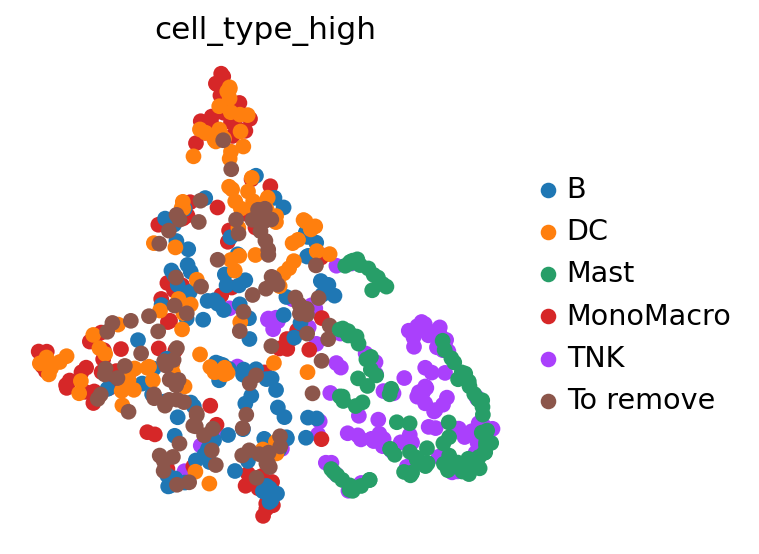

In [23]:
sc.pl.umap(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


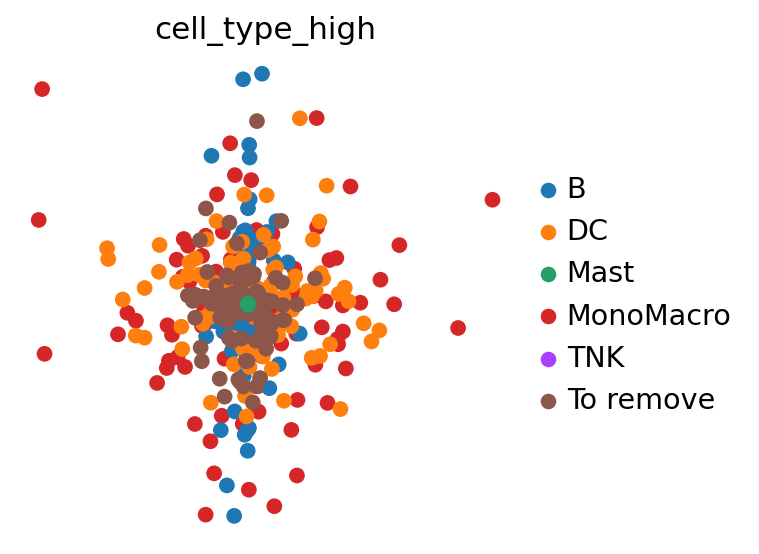

In [25]:
sc.tl.pca(signature_adata, svd_solver='arpack')
sc.pl.pca(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

In [22]:
# run PCA then generate UMAP plots
sc.pp.neighbors(signature_adata, use_rep="X")
sc.tl.umap(signature_adata, min_dist=0.3)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


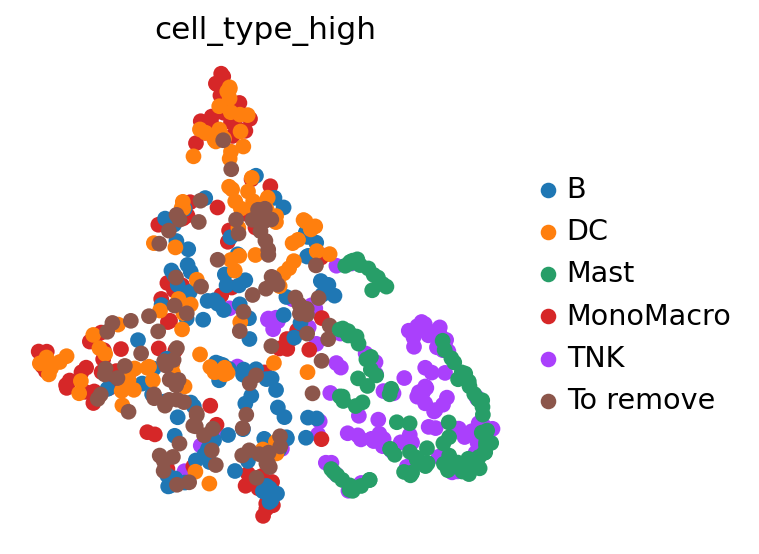

In [23]:
sc.pl.umap(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


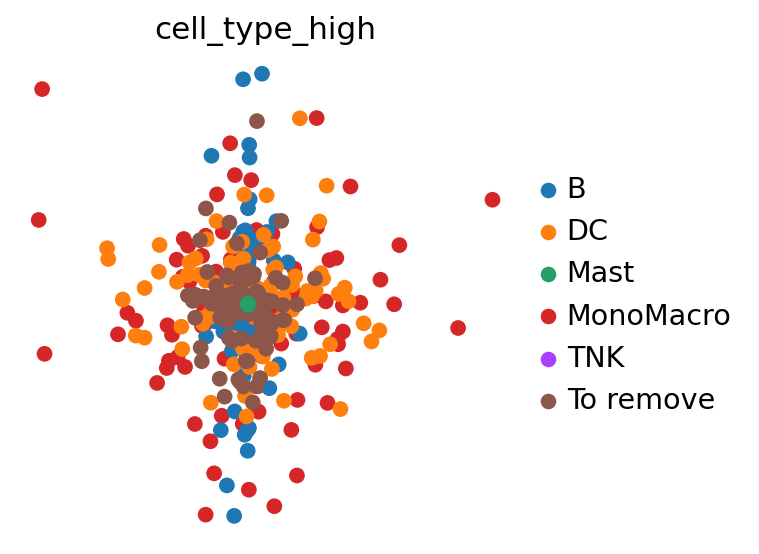

In [25]:
sc.tl.pca(signature_adata, svd_solver='arpack')
sc.pl.pca(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

# 2. Creating a signature matrix in latent space 

In [18]:
import random
from scipy.stats import pearsonr
import numpy as np

df_signature_denoised = pd.DataFrame()

num_cells = 1000
num_repeats = 100

dico_rpz = {}


for cell_type in adata.obs["cell_types_grouped"].unique():
        dico_rpz[cell_type] = []
        for repeat in range(num_repeats):
            seed = random.seed()
            sampled_cells = adata.obs[adata.obs['cell_types_grouped'] == cell_type].sample(n=num_cells,
                                                                                random_state=seed,replace = True).index
            #print(sampled_cells[:5])
            # Select the sampled cells from the DataFrame
            adata_sampled = adata[sampled_cells]
    
            # embeddings of single-cells
            # latent_sampled = model.get_latent_representation(adata_sampled)
            latent_sampled = model.module.z_encoder(torch.from_numpy(adata_sampled.layers["counts"].toarray()).to("cuda:0"))[1]
            # normalize in 1 direction 
            
            latent_sampled = latent_sampled.detach().cpu().numpy()

            correct = ((-np.inf < latent_sampled) *(latent_sampled < np.inf) * (1 - np.isnan(latent_sampled))).astype(bool)
            incorrect = (1-correct).astype(bool)
            
            number_incorrect = np.sum(incorrect)

            latent_sampled[incorrect] = 0.

            #latent_sampled[correct] = latent_sampled[correct] / np.abs(latent_sampled[correct]).sum(axis = 1)

            dim1_loc,dim2_loc = np.where(incorrect)
            latent_sampled[incorrect] = np.mean(latent_sampled[:,dim2_loc],axis=0)

            #if number_incorrect > 0:
                #print(f"For cell type {cell_type}, repeat {repeat+1}:")
                #print("Number of nans, infinities etc", np.sum(1-correct))
            

            mean_sampled_z = np.mean(latent_sampled,axis=0)
            dico_rpz[cell_type].append(mean_sampled_z.copy())
            




In [ ]:
def sanity_checks_metrics(model: scvi.model.SCVI,
                          adata: ad.AnnData,
                          batch_sizes: List[int],
                          n_repeats: int,
                          use_get_latent: bool=True) -> Dict:
    """Computes sanity check metrics for a given scVI model.

    Parameters
    ----------
    model: scvi.model.SCVI
        fitted scvi model
    adata: ad.AnnData
        Anndata object sotring the training set
    batch_sizes: List[int]
        List of batch size (# on sampled cells)
    n_repeats: int
        Number of repeats
    use_get_latent: bool
        Whether to use get_latent scvi built in function
        to infer the latent states. Is set to `False`, will
        use the module encoder directly.

    Returns
    -------
    Dict
        Dictionnary storing latent space metrics
    """
    metrics = {"corr": [], "kl": []}
    errors = {"corr": [], "kl": []}
    for n in tqdm.tqdm(batch_sizes):
        current_metrics = {"corr": [], "kl": []}
        for i in range(n_repeats):
            # Calculate the number of cells to sample from each cell type proportionally
            sampled_cells_per_type = adata.obs['cell_type'].value_counts(normalize=True) * n
            sampled_cells_per_type = sampled_cells_per_type.astype(int)

            # Perform stratified sampling for each cell type
            sampled_cells = []
            for cell_type, num_cells in sampled_cells_per_type.items():
                seed = random.seed()
                sampled_cells.extend(adata.obs[adata.obs['cell_type'] == cell_type].sample(n=num_cells,
                                                                                        random_state=seed).index)

            # Select the sampled cells from the DataFrame
            adata_sampled = adata[sampled_cells]

            # embeddings of single-cells
            if use_get_latent:
                latent_sampled = model.get_latent_representation(adata_sampled)
                mean_sampled_z = latent_sampled.mean(axis=0)
            else:
                dist_z, latent_sampled = model.module.z_encoder(torch.from_numpy(adata_sampled.layers["counts"].toarray()).to("cuda:0"))
                latent_sampled = latent_sampled.detach().cpu().numpy()
                mean_sampled_z = latent_sampled.mean(axis=0)
                mean_sampled_z = replace_inf(mean_sampled_z)

            # pseudo-bulk embedding
            if use_get_latent:
                pseudobulk_x = adata_sampled.layers["counts"].mean(axis=0) #.astype(int).astype(numpy.float32)
                adata_pseudobulk = create_anndata_pseudobulk(adata, pseudobulk_x)
                pseudobulk_z = model.get_latent_representation(adata_pseudobulk)
            else:
                dist_pseudobulk_z, pseudobulk_z = model.module.z_encoder(torch.from_numpy(pseudobulk_x).to("cuda:0"))
                pseudobulk_z = pseudobulk_z.detach().cpu().numpy().flatten()

                pseudobulk_z = replace_inf(pseudobulk_z)

            # Compute correlation
            print(mean_sampled_z.shape)
            print(pseudobulk_z.shape)
            pearson_corr = pearsonr(mean_sampled_z, pseudobulk_z.flatten())
            current_metrics["corr"].append(pearson_corr[0])

            # compute kl-divergence
            # kl = kl_divergence(dist_z,
            #                    dist_pseudobulk_z).sum(dim=-1)


        metrics["corr"].append(np.mean(current_metrics["corr"]))
        errors["corr"].append(np.std(current_metrics["corr"]))

    return metrics, errors

In [19]:
dico_rpz

{'TNK': [array([-1.9922867e+01,  2.1871547e+14,  1.7819394e+07,  1.4922597e+14,
          1.1870529e+04,  1.0149220e+04, -5.3096249e+01, -8.7627120e+06,
          2.8414688e+05,  2.2017326e+07], dtype=float32),
  array([-2.3719242e+01,  2.5215778e+07, -7.2367317e+01, -1.7861593e+11,
         -1.8990986e+01, -3.0718470e+01, -2.1324116e+01,  5.6106430e+01,
         -2.0845821e+01, -6.1168906e+05], dtype=float32),
  array([-1.6716018e+03, -2.5294189e+10,  5.7863052e+03,  4.1671144e+12,
          5.4867542e+02, -2.3528543e+01, -3.1620293e+01,  1.9016840e+04,
         -1.7034558e+03,  2.0341639e+10], dtype=float32),
  array([ 2.9831161e+12,  2.1570470e+11,  3.5568944e+08, -2.4827864e+14,
          9.9324150e+01, -3.6306638e+05, -2.0778410e+01,  6.1469562e+08,
         -5.8247115e+10, -7.0415754e+14], dtype=float32),
  array([ 6.6577216e+08, -4.1749065e+06, -6.5510069e+12,  1.3169245e+11,
          7.4187237e-01,  1.8813007e+02, -2.1568308e+01, -1.8209080e+13,
          1.9379490e+08, -7.085

In [20]:
obs = []
matrices = []
for key,value in dico_rpz.items():
    for repeat, repeat_rpz in enumerate(value):
        obs.append(key)
        matrices.append(repeat_rpz)
X = np.stack(matrices)

signature_adata = ad.AnnData(X= X, obs=obs )

In [21]:
signature_adata.obs["cell_type_high"] = signature_adata.obs[0]

In [22]:
# run PCA then generate UMAP plots
sc.pp.neighbors(signature_adata, use_rep="X")
sc.tl.umap(signature_adata, min_dist=0.3)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


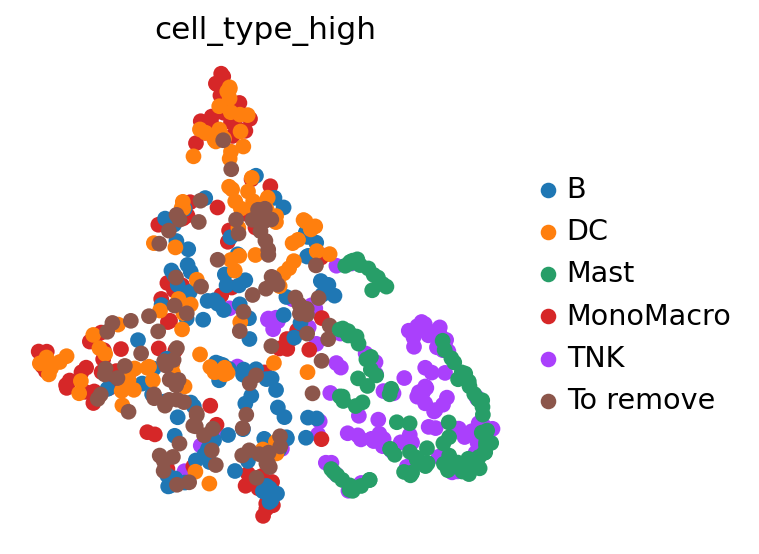

In [23]:
sc.pl.umap(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


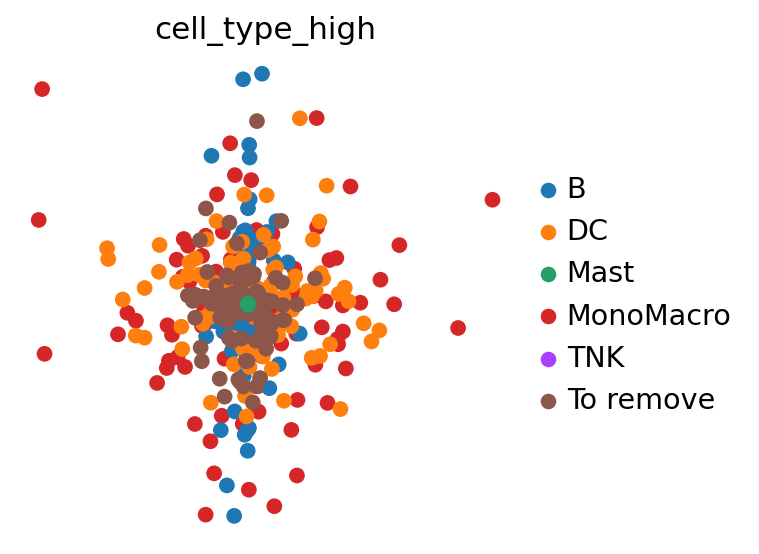

In [25]:
sc.tl.pca(signature_adata, svd_solver='arpack')
sc.pl.pca(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

In [17]:
means = []
stds = []
for cell_type in signature_adata.obs["cell_type_high"].unique():
    means.append(signature_adata[signature_adata.obs['cell_type_high'] == cell_type].X.mean(axis = 0))
    stds.append(signature_adata[signature_adata.obs['cell_type_high'] == cell_type].X.std(axis = 0))
    

In [93]:
means

[array([ 2.67881651e+12, -1.09729175e+14, -8.79701745e+13,  1.16617002e+14,
        -1.66037216e+02, -2.42745953e+05, -5.60644897e+02,  5.42639791e+14,
        -4.70940228e+12,  5.79052084e+12], dtype=float32),
 array([ 7.7623159e+14, -5.6130864e+14,  5.7545307e+11, -8.5559859e+13,
        -3.1582249e+01, -6.2986451e+08, -6.3841412e+01, -7.6830883e+13,
         2.9311578e+14, -8.7500812e+14], dtype=float32),
 array([-1.2462461e+15,  1.3316133e+15,  4.0329280e+14, -2.3088950e+15,
        -4.8132027e+14,  1.1973579e+14, -5.7612805e+14,  7.3256224e+14,
        -2.5258703e+14, -1.2745318e+14], dtype=float32),
 array([ 2.3130350e+11,  1.6319539e+14, -2.4973148e+13, -2.4063779e+14,
        -5.1523027e+00,  2.2369141e+03, -2.0954397e+08,  9.2423200e+14,
         4.8812976e+11,  1.8245165e+15], dtype=float32),
 array([ 6.76906307e+13, -1.43131074e+15, -1.49455467e+14, -8.89987151e+14,
         1.72576114e+14,  3.39767040e+13,  2.05914322e+12,  1.28554277e+14,
        -1.60275701e+13,  1.027777

In [94]:
stds

[array([8.0004965e+12, 5.3537495e+14, 2.6651978e+14, 3.2966991e+14,
        8.7576251e+02, 7.5843681e+05, 1.8110043e+04, 1.7367667e+15,
        1.3094419e+13, 1.1164624e+14], dtype=float32),
 array([2.8936886e+15, 9.1218942e+15, 1.3319478e+14, 5.7436227e+15,
        7.2230536e-01, 4.6351954e+09, 7.5747585e-01, 3.5121806e+14,
        9.4777916e+14, 5.5151009e+15], dtype=float32),
 array([1.61486677e+15, 2.30494708e+15, 1.35290718e+15, 2.46584085e+15,
        1.72415100e+15, 6.35244454e+14, 1.02427836e+15, 3.64122952e+15,
        1.52496626e+15, 3.21381370e+15], dtype=float32),
 array([2.2176798e+12, 9.6646374e+15, 2.1660135e+15, 2.7539261e+15,
        6.6255398e+00, 4.5770366e+03, 4.5991350e+08, 6.4291623e+15,
        3.2406053e+13, 2.1351384e+15], dtype=float32),
 array([2.9297133e+14, 5.9340283e+15, 1.5999984e+15, 3.4488786e+15,
        5.2605766e+14, 1.6721184e+15, 1.0987558e+13, 5.2888425e+14,
        2.6836471e+14, 5.8007222e+15], dtype=float32),
 array([1.65851547e+02, 3.87596000e

## 3.1 Khalil s code 

In [97]:
import random
from scipy.stats import pearsonr
import numpy as np

N = 10

# Define the number of cells you want to sample

batch_size = [32, 64, 128, 256, 512, 1024, 2048, 4096] #, 8192, 16384, 32768, 65536, 131072] 

corrs = []
pvals = []

for n in batch_size:
    for i in range(N):
        current_corrs = []
        current_pvals = []
        # Calculate the number of cells to sample from each cell type proportionally
        sampled_cells_per_type = adata.obs['cell_types_grouped'].value_counts(normalize=True) * n
        sampled_cells_per_type = sampled_cells_per_type.astype(int)

        # Perform stratified sampling for each cell type
        sampled_cells = []
        for cell_type, num_cells in sampled_cells_per_type.items():
            seed = random.seed()
            sampled_cells.extend(adata.obs[adata.obs['cell_types_grouped'] == cell_type].sample(n=num_cells,
                                                                                    random_state=seed).index)

        # print(sampled_cells)
        # Select the sampled cells from the DataFrame
        adata_sampled = adata[sampled_cells]

        # embeddings of single-cells
        # latent_sampled = model.get_latent_representation(adata_sampled)
        latent_sampled = model.module.z_encoder(torch.from_numpy(adata_sampled.layers["counts"].toarray()).to("cuda:0"))[1]
        latent_sampled = latent_sampled.detach().cpu().numpy()
        mean_sampled_z = latent_sampled.mean(axis=0)

        # pseudo-bulk embedding
        pseudobulk_x = adata_sampled.layers["counts"].mean(axis=0) #.astype(int).astype(numpy.float32)
        pseudobulk_z = model.module.z_encoder(torch.from_numpy(pseudobulk_x).to("cuda:0"))[1]
        pseudobulk_z = pseudobulk_z.detach().cpu().numpy().flatten()

        print(mean_sampled_z, pseudobulk_z)
        
        # Compute correlation
        pearson_corr = pearsonr(mean_sampled_z, pseudobulk_z)
        #print(pearson_corr[0], pearson_corr[1])
        current_corrs.append(pearson_corr[0])
        current_pvals.append(pearson_corr[1])
    corrs.append(np.mean(current_corrs))

[-1.7422138e+01  2.4942222e+05 -2.4163580e+01 -1.2464485e+05
  2.9432315e-01 -1.6734688e+01 -2.3303061e+01  2.6266055e+00
  2.5256209e+00 -7.3564203e+04] [-14.369582    -0.3127091  -20.271059     5.3476133   -0.24070644
 -15.103247   -24.1961       0.22890282   2.7797675   -4.386601  ]
[ 4.9285331e+00 -8.9971545e+14 -4.4012089e+01           -inf
 -3.6742141e+00 -1.6234867e+01 -3.3837078e+01 -3.2955133e+02
 -1.1004988e+01  1.2908946e+04] [-1.8710110e+01 -9.1542063e+00 -4.2563744e+01  1.2611506e+01
 -4.4466162e+00 -1.1247343e+01 -3.5126404e+01 -4.0722724e-02
 -4.2365623e+00 -1.3876204e+01]


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4445: RuntimeWarning: invalid value encountered in subtract
  xm = x.astype(dtype) - xmean


ValueError: array must not contain infs or NaNs

In [99]:
v = np.random.rand(2,3)

In [100]:
v[1,0] = np.nan
v[0,2] = np.nan

In [101]:
v

array([[0.45995747, 0.97710836,        nan],
       [       nan, 0.34327768, 0.03500222]])

In [105]:

np.where(v!=v)

(array([0, 1]), array([2, 0]))

In [106]:
-np.inf != -np.inf

False